<a href="https://colab.research.google.com/github/HuangJin-De/Machine-Learning-in-Atmospheric-Thermodynamics/blob/master/hw03-3/hw03-3b.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
! rm -rf Machine-Learning-in-Atmospheric-Thermodynamics
! git clone https://github.com/HuangJin-De/Machine-Learning-in-Atmospheric-Thermodynamics.git

Cloning into 'Machine-Learning-in-Atmospheric-Thermodynamics'...
remote: Enumerating objects: 470, done.
remote: Counting objects: 100% (40/40), done.
remote: Compressing objects: 100% (38/38), done.
remote: Total 470 (delta 17), reused 9 (delta 2), pack-reused 430
Receiving objects: 100% (470/470), 186.40 MiB | 16.27 MiB/s, done.
Resolving deltas: 100% (175/175), done.


In [2]:
import numpy as np
import pandas as pd
import seaborn as sns

from sklearn.preprocessing import StandardScaler, MinMaxScaler  
from sklearn.model_selection import train_test_split

path='Machine-Learning-in-Atmospheric-Thermodynamics/hw03-3'
filen=path+'/data/era5_stn_the_the.dat'

data=np.fromfile(filen,dtype=np.float32)
data=data.reshape(-1,33)

x=data[:,0:32]
y=data[:,32].reshape(-1,1)#.astype(int)

print(x.shape,x[1,:])
print(y.shape,y[1,:])

x_temp,x_valid,y_temp,y_valid=train_test_split(x,y,test_size=0.2,random_state=1)
x_train,x_test,y_train,y_test=train_test_split(x_temp,y_temp,test_size=0.2,random_state=1)

label_unique, counts=np.unique(y_temp,return_counts=True)
print(label_unique, counts)
weight=[sum(counts)/c for c in counts]
print(weight)

x_temp=x_temp.reshape(-1,2,16)
x_train=x_train.reshape(-1,2,16)
x_test=x_test.reshape(-1,2,16)
x_valid=x_valid.reshape(-1,2,16)

scaler=[]
scaler.append(MinMaxScaler())
scaler.append(MinMaxScaler())

for i in range(0,2):
  x_temp[:,i,:]=scaler[i].fit_transform(x_temp[:,i,:])
  x_train[:,i,:]=scaler[i].transform(x_train[:,i,:])
  x_test[:,i,:]=scaler[i].transform(x_test[:,i,:])
  x_valid[:,i,:]=scaler[i].transform(x_valid[:,i,:])
  
x_temp=x_temp.reshape(-1,32)
x_train=x_train.reshape(-1,32)
x_test=x_test.reshape(-1,32)
x_valid=x_valid.reshape(-1,32)

print('finished')

(9417, 32) [403.0489  390.99118 380.73993 373.46396 365.30322 361.7616  359.39383
 356.67798 353.31937 351.36148 350.46713 349.686   349.19373 349.51108
 353.59616 352.37067 403.0489  390.99118 380.73993 373.46396 365.30322
 361.7616  359.39383 356.67798 353.31937 351.36148 350.46713 349.686
 349.19373 349.51108 353.59616 352.37067]
(9417, 1) [0.]
[0. 1.] [2130 5403]
[3.536619718309859, 1.394225430316491]
finished


In [3]:
import torch
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler

class TrainData(Dataset):
    
    def __init__(self, x_data, y_data):
        self.x_data = x_data
        self.y_data = y_data
        
    def __getitem__(self, index):
        return self.x_data[index], self.y_data[index]
        
    def __len__ (self):
        return len(self.x_data)

train_data=TrainData(torch.FloatTensor(x_train),torch.FloatTensor(y_train))
test_data=TrainData(torch.FloatTensor(x_test),torch.FloatTensor(y_test))
valid_data=TrainData(torch.FloatTensor(x_valid),torch.FloatTensor(y_valid))

BATCH_SIZE=64
weight_train=[weight[k] for k in y_train.reshape(-1).astype(int)]
sampler_train=WeightedRandomSampler(weight_train,len(y_train))
train_loader=DataLoader(dataset=train_data,sampler=sampler_train,batch_size=BATCH_SIZE)

weight_test=[weight[k] for k in y_test.reshape(-1).astype(int)]
sampler_test=WeightedRandomSampler(weight_test,len(y_test))
test_loader=DataLoader(dataset=test_data,sampler=sampler_test,batch_size=BATCH_SIZE)

valid_loader=DataLoader(dataset=valid_data,batch_size=1)

print('finished')

finished


In [4]:
from torch import nn
from torchvision.transforms import ToTensor, Lambda, Compose
import time

class BinaryClassification(nn.Module):
  def __init__(self):
    super(BinaryClassification, self).__init__()
    self.BC = nn.Sequential(
      nn.Linear(32, 256),   
      nn.ReLU(),     
      nn.BatchNorm1d(256),   
      nn.Linear(256, 192),
      nn.ReLU(),
      nn.BatchNorm1d(192),
      nn.Dropout(p=0.1),
      nn.Linear(192, 1)
    )

  def forward(self, x):
    freq = self.BC(x)
    binary = freq #torch.round(freq)
    return binary

print('defined model')

defined model


In [5]:
device = "cuda" if torch.cuda.is_available() else "cpu"

model = BinaryClassification().to(device)

loss_fn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-5)

def train(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)

    model.train()
    train_loss=0

    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)

        pred = model(X)  
        loss = loss_fn(pred, y) 
        train_loss += loss.item()

        optimizer.zero_grad()  
        loss.backward()      
        optimizer.step()      
       
        #if batch % 100 == 0:
        #    loss, current = loss.item(), batch * len(X)
        #    print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

    train_loss /= num_batches
    return train_loss

def test(dataloader, model, loss_fn):
    size = len(dataloader.dataset)

    num_batches = len(dataloader)
    model.eval()
    test_loss, correct = 0, 0

    with torch.no_grad(): 
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)

            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (torch.round(torch.sigmoid(pred))==y).sum().float()

    test_loss /= num_batches
    correct /= size
    print(f"Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f}")
    return test_loss

# training start
epochs=150

tt=time.time()
train_loss=[]
test_loss=[]
for t in range(epochs):
    print(f"Epoch {t+1}-------------------------------")
    loss = train(train_loader, model, loss_fn, optimizer)
    train_loss.append(loss)
    loss = test(test_loader, model, loss_fn)
    test_loss.append(loss)

elapse=time.time()-tt
print(elapse)

torch.save(model.state_dict(),'model.pkl')

Epoch 1-------------------------------
Accuracy: 67.6%, Avg loss: 0.597151
Epoch 2-------------------------------
Accuracy: 68.9%, Avg loss: 0.588963
Epoch 3-------------------------------
Accuracy: 72.7%, Avg loss: 0.563989
Epoch 4-------------------------------
Accuracy: 70.5%, Avg loss: 0.579122
Epoch 5-------------------------------
Accuracy: 71.5%, Avg loss: 0.570445
Epoch 6-------------------------------
Accuracy: 72.5%, Avg loss: 0.559112
Epoch 7-------------------------------
Accuracy: 71.4%, Avg loss: 0.542108
Epoch 8-------------------------------
Accuracy: 74.1%, Avg loss: 0.527009
Epoch 9-------------------------------
Accuracy: 72.6%, Avg loss: 0.549033
Epoch 10-------------------------------
Accuracy: 72.3%, Avg loss: 0.539036
Epoch 11-------------------------------
Accuracy: 72.9%, Avg loss: 0.543928
Epoch 12-------------------------------
Accuracy: 74.1%, Avg loss: 0.528863
Epoch 13-------------------------------
Accuracy: 74.2%, Avg loss: 0.537352
Epoch 14-------------

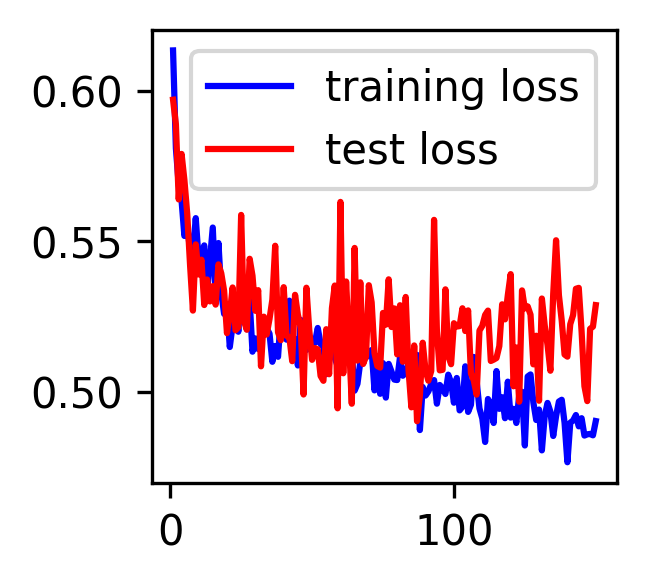

In [6]:
import matplotlib.pyplot as plt

fig,ax=plt.subplots(figsize=(2,2),dpi=300)
ax.plot(np.arange(1,epochs+1),train_loss,'b',np.arange(1,epochs+1),test_loss,'r')
plt.legend(["training loss","test loss"])









Accuracy is  0.7213375796178344
Precision is  0.8827392120075047
Recall is  0.7017151379567487
F1 score is  0.7818861653510594


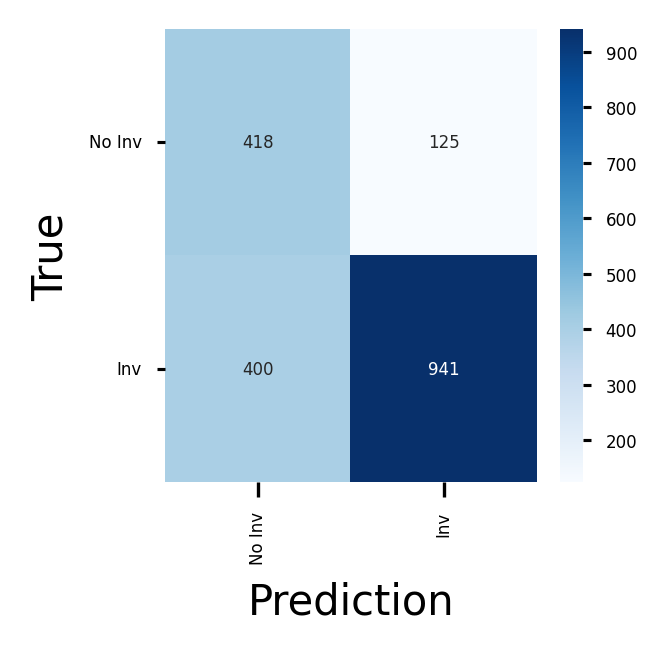

In [7]:
import seaborn as sn

model2 = BinaryClassification()
model2.load_state_dict(torch.load('model.pkl'))

classes = [
    "No Inv",
    "Inv"
]

model2.eval()

cm=np.zeros((len(classes),len(classes)))

#test_loader=DataLoader(test_data,sampler=sampler_test,batch_size=1)
xa=[]
xb=[]
xc=[]
xd=[]
for x,y in valid_loader:
  pred = model2(x)
  pred = torch.round(torch.sigmoid(pred))
  x1=pred.detach().numpy().astype(int)
  y1=y.detach().numpy().astype(int)
  cm[x1,y1]+=1
  #print(f'預測值："{pred[0].argmax(0)}" / 實際值："{y[0]}"')

  for n in range(0,y1.shape[0]):
    if x1[n]==y1[n] & y1[n]==0:
      xa.append(x[n,:])
    if x1[n]!=y1[n] & y1[n]==0:
      xb.append(x[n,:])
    if x1[n]!=y1[n] & y1[n]==1:
      xc.append(x[n,:])
    if x1[n]==y1[n] & y1[n]==1:
      xd.append(x[n,:])

plt.rcParams.update({'ytick.major.size':2,'ytick.major.width':0.75})
fig,ax=plt.subplots(figsize=(2,2),dpi=300)
ax=sn.heatmap(cm.transpose(),xticklabels=classes,yticklabels=classes,annot=True,cmap='Blues',fmt='g',annot_kws={"fontsize":4})

plt.yticks(rotation=0) 
plt.xticks(rotation=90)
sn.set(font_scale=0.5)
ax.tick_params(labelsize=4) 
ax.figure.axes[-1].tick_params(labelsize=4)
plt.xlabel('Prediction')
plt.ylabel('True')

print('\n\n\n\n\n\n\n')
print('Accuracy is ',np.diagonal(cm).sum()/cm.sum())
print('Precision is ',cm[1,1]/cm[1,:].sum())
print('Recall is ',cm[1,1]/cm[:,1].sum())
print('F1 score is ',2.*(cm[1,1]/cm[:,1].sum()*cm[1,1]/cm[1,:].sum())/(cm[1,1]/cm[:,1].sum()+cm[1,1]/cm[1,:].sum()))

418 125 400 941
0
2
4
6


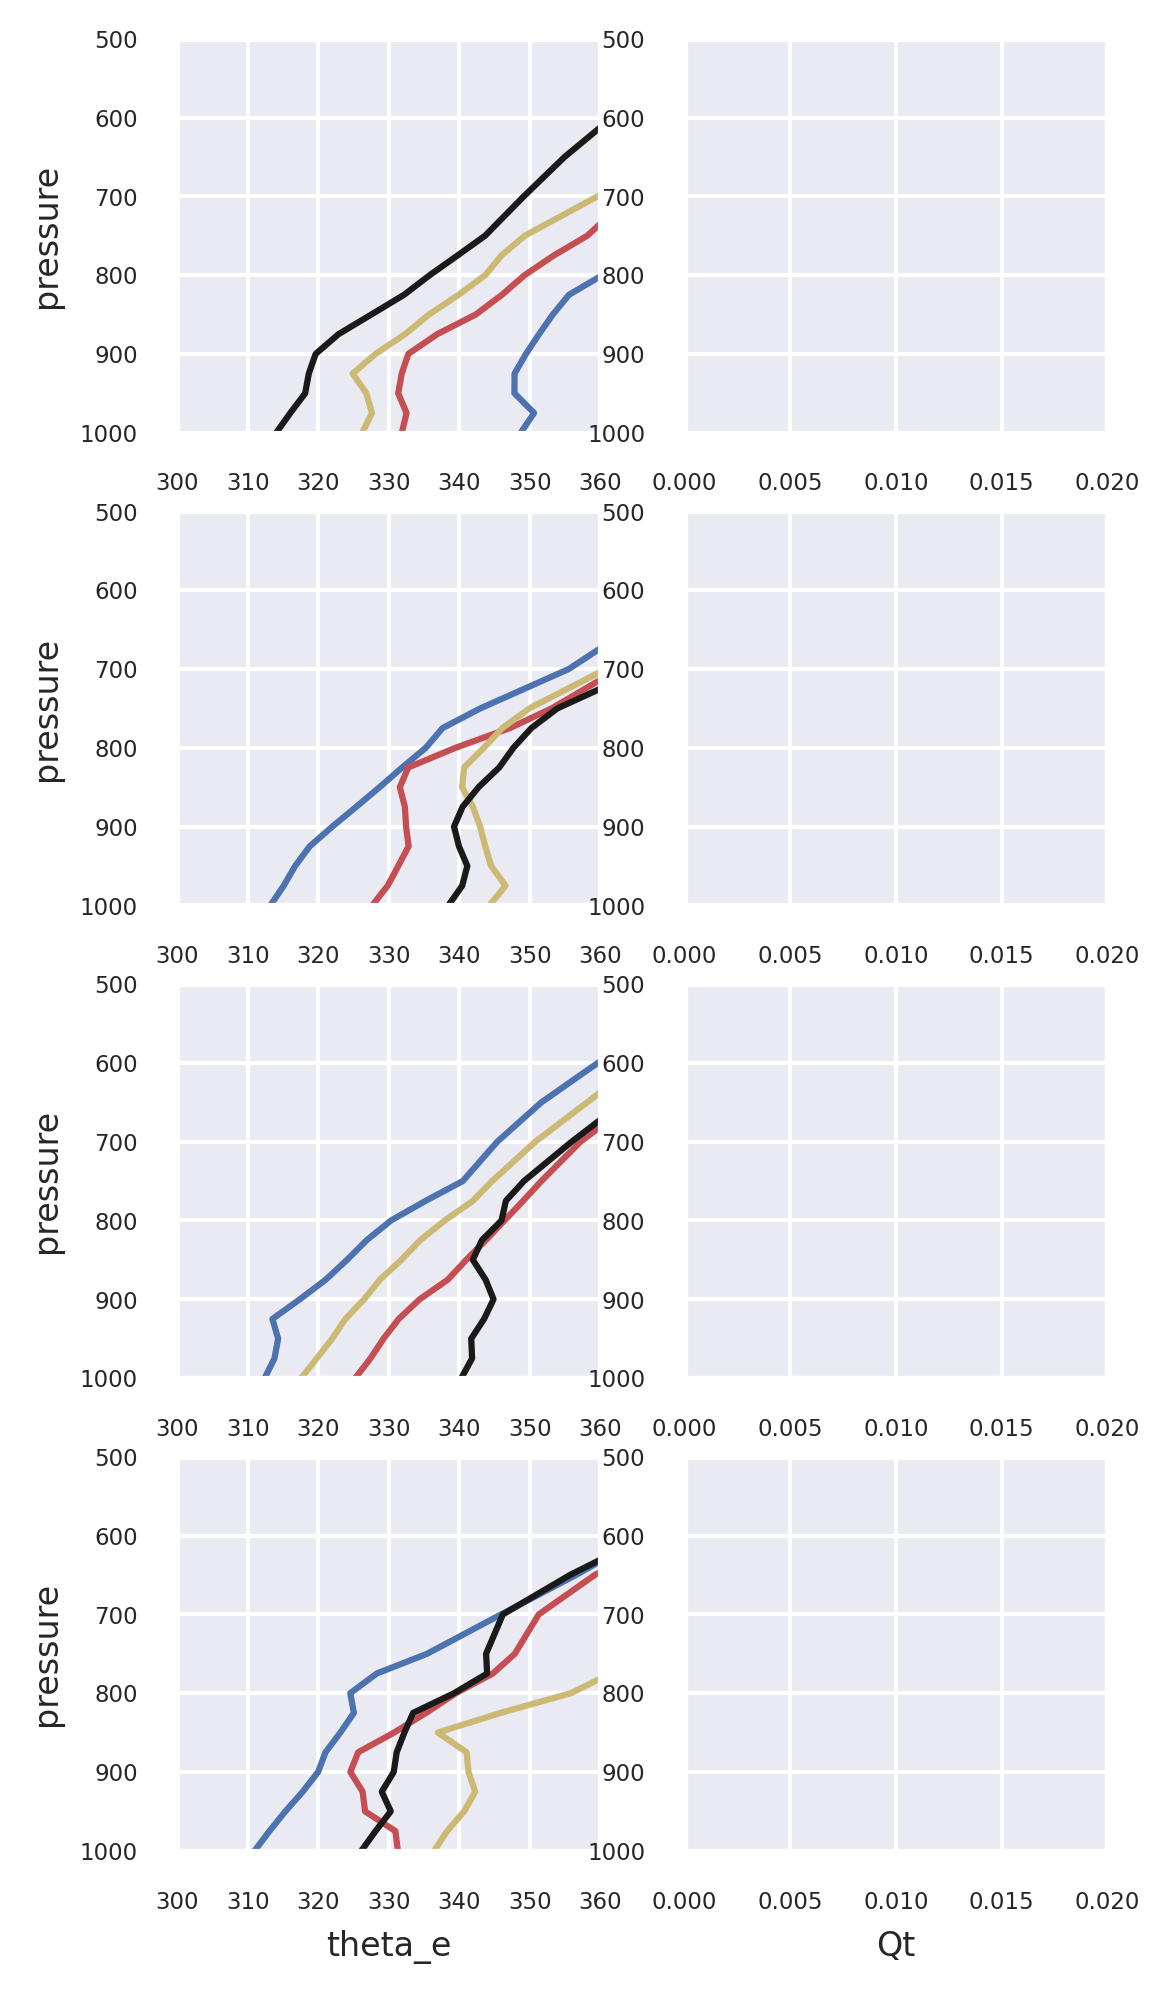

In [11]:
print(len(xa),len(xb),len(xc),len(xd))
p=np.flip(np.array([1000.,975.,950.,925.,900.,875.,850.,825.,800.,775.,750.,700.,650.,600.,550.,500.]),0)
fig,ax=plt.subplots(nrows=4,ncols=2,figsize=(4,8),dpi=300)
ax=ax.flatten()

for i in range(0,8,2):
  print(i)
  ii=i*10+4
  if i==0:
    xdraw=scaler[0].inverse_transform(xa[ii][0:16].reshape(-1,16))
    xdraw=np.append(xdraw,scaler[0].inverse_transform(xa[ii+20][0:16].reshape(-1,16)),0)
    xdraw=np.append(xdraw,scaler[0].inverse_transform(xa[ii+13][0:16].reshape(-1,16)),0)
    xdraw=np.append(xdraw,scaler[0].inverse_transform(xa[ii+12][0:16].reshape(-1,16)),0)
    xdraw2=scaler[1].inverse_transform(xa[ii][16:32].reshape(-1,16))
    xdraw2=np.append(xdraw2,scaler[1].inverse_transform(xa[ii+20][16:32].reshape(-1,16)),0)
    xdraw2=np.append(xdraw2,scaler[1].inverse_transform(xa[ii+13][16:32].reshape(-1,16)),0)
    xdraw2=np.append(xdraw2,scaler[1].inverse_transform(xa[ii+12][16:32].reshape(-1,16)),0)
  if i==2:
    xdraw=scaler[0].inverse_transform(xb[ii][0:16].reshape(-1,16))
    xdraw=np.append(xdraw,scaler[0].inverse_transform(xb[ii+20][0:16].reshape(-1,16)),0)
    xdraw=np.append(xdraw,scaler[0].inverse_transform(xb[ii+13][0:16].reshape(-1,16)),0)
    xdraw=np.append(xdraw,scaler[0].inverse_transform(xb[ii+12][0:16].reshape(-1,16)),0)
    xdraw2=scaler[1].inverse_transform(xb[ii][16:32].reshape(-1,16))
    xdraw2=np.append(xdraw2,scaler[1].inverse_transform(xb[ii+20][16:32].reshape(-1,16)),0)
    xdraw2=np.append(xdraw2,scaler[1].inverse_transform(xb[ii+13][16:32].reshape(-1,16)),0)
    xdraw2=np.append(xdraw2,scaler[1].inverse_transform(xb[ii+12][16:32].reshape(-1,16)),0)
  if i==4:
    xdraw=scaler[0].inverse_transform(xc[ii][0:16].reshape(-1,16))
    xdraw=np.append(xdraw,scaler[0].inverse_transform(xc[ii+20][0:16].reshape(-1,16)),0)
    xdraw=np.append(xdraw,scaler[0].inverse_transform(xc[ii+13][0:16].reshape(-1,16)),0)
    xdraw=np.append(xdraw,scaler[0].inverse_transform(xc[ii+12][0:16].reshape(-1,16)),0)
    xdraw2=scaler[1].inverse_transform(xc[ii][16:32].reshape(-1,16))
    xdraw2=np.append(xdraw2,scaler[1].inverse_transform(xc[ii+20][16:32].reshape(-1,16)),0)
    xdraw2=np.append(xdraw2,scaler[1].inverse_transform(xc[ii+13][16:32].reshape(-1,16)),0)
    xdraw2=np.append(xdraw2,scaler[1].inverse_transform(xc[ii+12][16:32].reshape(-1,16)),0)
  if i==6:
    xdraw=scaler[0].inverse_transform(xd[ii][0:16].reshape(-1,16))
    xdraw=np.append(xdraw,scaler[0].inverse_transform(xd[ii+20][0:16].reshape(-1,16)),0)
    xdraw=np.append(xdraw,scaler[0].inverse_transform(xd[ii+13][0:16].reshape(-1,16)),0)
    xdraw=np.append(xdraw,scaler[0].inverse_transform(xd[ii+12][0:16].reshape(-1,16)),0)
    xdraw2=scaler[1].inverse_transform(xd[ii][16:32].reshape(-1,16))
    xdraw2=np.append(xdraw2,scaler[1].inverse_transform(xd[ii+20][16:32].reshape(-1,16)),0)
    xdraw2=np.append(xdraw2,scaler[1].inverse_transform(xd[ii+13][16:32].reshape(-1,16)),0)
    xdraw2=np.append(xdraw2,scaler[1].inverse_transform(xd[ii+12][16:32].reshape(-1,16)),0)
  
  ax[i].plot(xdraw[0,:],p,'b',xdraw[1,:],p,'r',xdraw[2,:],p,'y',xdraw[3,:],p,'k')
  ax[i].set_ylim([1000,500])
  ax[i].set_xlim([300,360])
  ax[i].set_xlabel('theta_e',fontsize=8)
  ax[i].set_ylabel('pressure',fontsize=8)

  ax[i+1].plot(xdraw2[0,:],p,'b',xdraw2[1,:],p,'r',xdraw2[2,:],p,'y',xdraw2[3,:],p,'k')
  ax[i+1].set_ylim([1000,500])
  ax[i+1].set_xlim([0.,0.02])
  ax[i+1].set_xlabel('Qt',fontsize=8)
  


torch.Size([1884, 32]) torch.Size([1884, 1])
0.8057646433559518


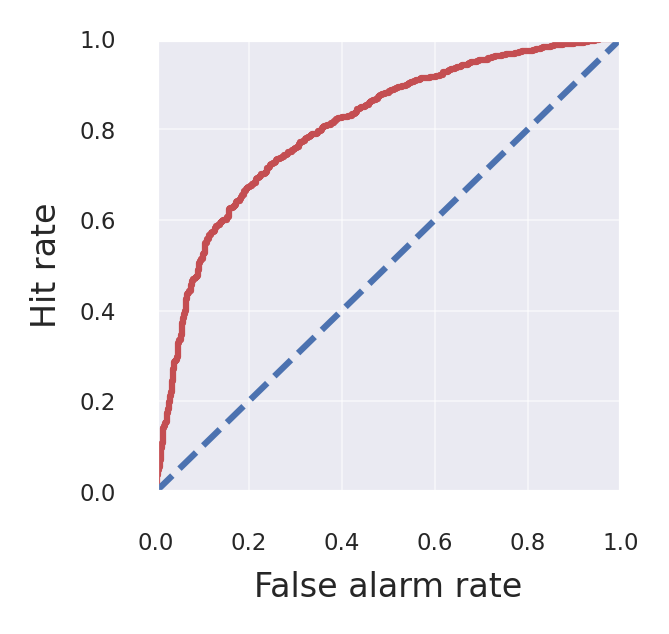

In [9]:
from sklearn.metrics import roc_curve, roc_auc_score, auc

valid_loader=DataLoader(dataset=valid_data,batch_size=10000)
for x,y in valid_loader:
  print(x.shape,y.shape)
  pred = model2(x)
  pred = torch.sigmoid(pred)
  x1=pred.detach().numpy()
  y1=y.detach().numpy()

rocx,rocy,_=roc_curve(y1,x1)
roc_area=roc_auc_score(y1,x1)
print(roc_area)

fig,ax=plt.subplots(figsize=(2,2),dpi=300)
ax.plot(rocx,rocy,'r-',[0, 1],[0, 1],'b--')
ax.set_ylim([0,1])
ax.set_xlim([0,1])
ax.set_xlabel('False alarm rate',fontsize=8)
ax.set_ylabel('Hit rate',fontsize=8)
ax.grid(lw=0.5,alpha=0.5)